In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb


# load files 

In [3]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
direction = 'UD'

SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
                  , squeeze_me =True)
RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
                  , squeeze_me =True)
MBExp   = loadmat(exp_folder+'merge\merge_0505_GP_s=60_OUsmooth_1Hz_'+direction+'_6.5v0mW.mat'
                  , squeeze_me =True)

In [4]:
BarPos = MBExp['bin_pos']
BSigma = 60

In [5]:
RFprop = RFprop['RF_properties']

In [6]:
STK = SVDnSTK['gauss_RF']

# plot STK

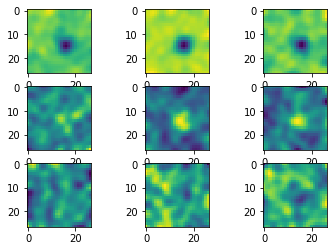

In [7]:
cn = 42
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax.flatten()[i].imshow(STK[i,:,:,cn-1])

# plot SK

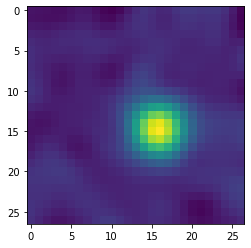

In [8]:
SK = SVDnSTK['SVD_SK'][cn-1]
plt.imshow(SK)

In [9]:
def Gaussian_filter_2d_Rot(x, y, x0, y0, xs, ys, angle, A):
    cx = x[np.newaxis,:]*np.ones_like(y)[:,np.newaxis]  -x0
    cy = np.ones_like(x)[np.newaxis,:]*y[:,np.newaxis]-y0
    rx =  cx*np.cos(angle) - cy*np.sin(angle) 
    ry =  cx*np.sin(angle) + cy*np.cos(angle)
    return A*(np.exp(-((rx/xs)**2+(ry/ys)**2)/2)),  x-x0, y-y0

In [10]:
micro_per_pixel = BS['micro_per_pixel']
RFellipse, xaxis, yaxis = Gaussian_filter_2d_Rot(
                                np.arange(1,801), np.arange(1,601), RFprop[cn-1]['X_Coor'], RFprop[cn-1]['Y_Coor'], 
                                RFprop[cn-1]['X_Width']/1.5/micro_per_pixel, RFprop[cn-1]['Y_Width']/1.5/micro_per_pixel,
                                RFprop[cn-1]['Angle'], RFprop[cn-1]['Amplitude'])

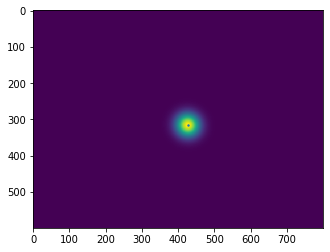

In [11]:
## SVD_SK on display area (whole OLED)
plt.imshow(RFellipse)
plt.scatter(RFprop[cn-1]['X_Coor']-1, RFprop[cn-1]['Y_Coor']-1, s=2)

316


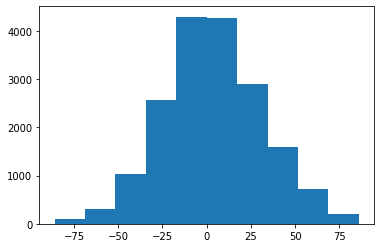

In [12]:
plt.hist(BarPos)
print(int(RFprop[cn-1]['Y_Coor']-0.5))

# conv[SK, Bar]

In [13]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))

In [14]:
Inten2u = []
if direction == 'UD':
    bpu, bpui = np.unique(BarPos, return_inverse=True)
    for bp in bpu:
        bar =  Gaussian_filter_1d((np.arange(1,601)-(bp+300)), BSigma)
        bar = bar[:, np.newaxis]*np.ones(800)[np.newaxis,:]
        bar[:300-94-1, :] = 0
        bar[300+94:, :] = 0
        bar[:, :400-94-1] = 0
        bar[:, 400+94:] = 0
        Inten2u.append(np.sum(bar*RFellipse))
Inten = np.array(Inten2u)[bpui]

# MI and STA

(-1, 1)

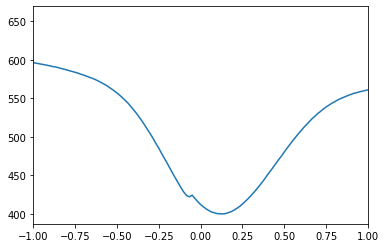

In [21]:
x = np.array(Inten)
dt=1/60.
T=np.arange(len(x))*dt+dt
rstate, _ = np.histogram(MBExp['reconstruct_spikes'][cn-1], np.append(0,T))
nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')

plt.plot(T-T[int(len(T)/2)], nXcorr)
plt.xlim([-1, 1])

In [ ]:
x = BarPos.copy()
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')
XcT = T-T[int(len(T)/2)]
plt.plot(nXcorr[np.arange(np.where(XcT == -1)[0],np.where(XcT == 1)[0])])